### Simple 1D Richards' Equation Model

This is a 1D Richards' equation model, written by Andrew Ireson, 3 November 2015.


In [1]:
# Import all of the basic libraries (you will always need these)
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
plt.style.use('ggplot')

# Import a library that contains soil moisture properties and functions
import vanGenuchten as vg

# Import ODE solvers
from scipy.interpolate import interp1d
from scipy.integrate import odeint

# Select which soil properties to use
p=vg.HygieneSandstone()
# p = vg.BeitNetofaClay()
# p = vg.TouchetSiltLoam()
p = vg.SiltLoamGE3()

In [2]:
# Richards equation solver
# This is a function that calculated the right hand side of Richards' equation. You
# will not need to modify this function, unless you are doing something advanced. 
# This block of code must be executed so that the function can be later called.

def RichardsModel(psi,t,dz,n,p,vg,qTop,qBot,psiTop,psiBot):
       
    # Basic properties:
    C=vg.CFun(psi,p)
   
    # initialize vectors:
    q=np.zeros(n+1)
    
    # Upper boundary
    if qTop == []:
        KTop=vg.KFun(np.zeros(1)+psiTop,p)
        q[n]=-KTop*((psiTop-psi[n-1])/dz*2+1)
    else:
        q[n]=qTop
    
    # Lower boundary
    if qBot == []:
        if psiBot == []:
            # Free drainage
            KBot=vg.KFun(np.zeros(1)+psi[0],p)
            q[0]=-KBot  # 
        else:
            # Type 1 boundary
            KBot=vg.KFun(np.zeros(1)+psiBot,p)
            q[0]=-KBot*((psi[0]-psiBot)/dz*2+1.0)    
    else:
        # Type 2 boundary
        q[0]=qBot

    # Internal nodes
    i=np.arange(0,n-1)
    Knodes=vg.KFun(psi,p)
    Kmid=(Knodes[i+1]+Knodes[i])/2.0
    
    j=np.arange(1,n)
    q[j]=-Kmid*((psi[i+1]-psi[i])/dz+1.0)
    
    
    # Continuity
    i=np.arange(0,n)
    dpsidt=(-(q[i+1]-q[i])/dz)/C
    
    return dpsidt

In [3]:
psi = np.linspace(-10,0)
theta = vg.thetaFun(psi,p)
C=vg.CFun(psi,p)
K=vg.KFun(psi,p)

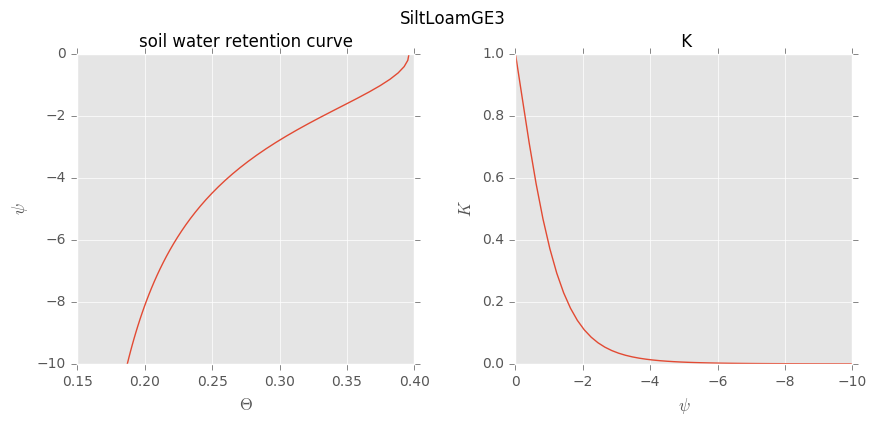

In [4]:
plt.figure(figsize = (10, 4))
plt.subplots_adjust(wspace = .3)
plt.subplot(121)
plt.plot( theta, psi)
plt.xlabel("$ \Theta $")
plt.ylabel("$\psi$")
plt.title("soil water retention curve", fontsize = 12)
#plt.gca().invert_yaxis()

plt.subplot(122)
plt.plot(  psi, K/p['Ks'], )
plt.xlabel("$\psi$")
plt.ylabel("$K$")
plt.title(" K", fontsize = 12)
plt.gca().invert_xaxis()
t = plt.suptitle(p['name'], fontsize = 12); t.set_y(1.01)

In [5]:
# This block of code sets up and runs the model

# Boundary conditions
qTop= -0.01
qBot= []
psiTop= []
psiBot= []

# Grid in space
dz=0.1
ProfileDepth=5
z=np.arange(dz/2.0,ProfileDepth,dz)
n=z.size

# Grid in time
t = np.linspace(0,20,101)

# Initial conditions
psi0=-z

# Solve
psi=odeint(RichardsModel,psi0,t,args=(dz,n,p,vg,qTop,qBot,psiTop,psiBot),mxstep=5000000);
#print "Model run successfully"    

In [6]:
# Post process model output to get useful information

# Get water content
theta=vg.thetaFun(psi,p)


In [7]:
# Get total profile storage
S=theta.sum(axis=1)*dz


In [8]:
# Get change in storage [dVol]
dS=np.zeros(S.size)
dS[1:]=np.diff(S)/(t[1]-t[0])

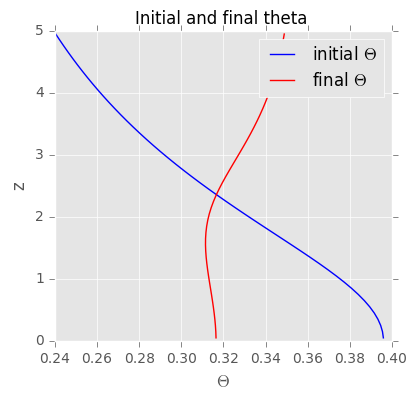

In [9]:
plt.figure(figsize = (10, 4))
plt.subplots_adjust(wspace = .3)
plt.subplot(121)
plt.plot( theta[0, :],  z, 'b',  label = 'initial $\Theta$')
plt.plot( theta[-1, :], z, 'r', label = 'final $\Theta$')
plt.xlabel("$ \Theta $")
plt.ylabel("z")
plt.legend()
plt.title("Initial and final theta ", fontsize = 12)
# z = 5 is the soil surface, confusingly

In [10]:
# Get infiltration flux
if qTop == []:
    KTop=vg.KFun(np.zeros(1)+psiTop,p)
    qI=-KTop*((psiTop-psi[:,n-1])/dz*2+1)
else:
    qI=np.zeros(t.size)+qTop

In [11]:
# Get discharge flux
if qBot == []:
    if psiBot == []:
        # Free drainage
        KBot=vg.KFun(psi[:,0],p)
        qD=-KBot
    else:
        # Type 1 boundary
        KBot=vg.KFun(np.zeros(1)+psiBot,p)
        qD=-KBot*((psi[:,0]-psiBot)/dz*2+1.0)
else:
    qD=np.zeros(t.size)+qBot
    

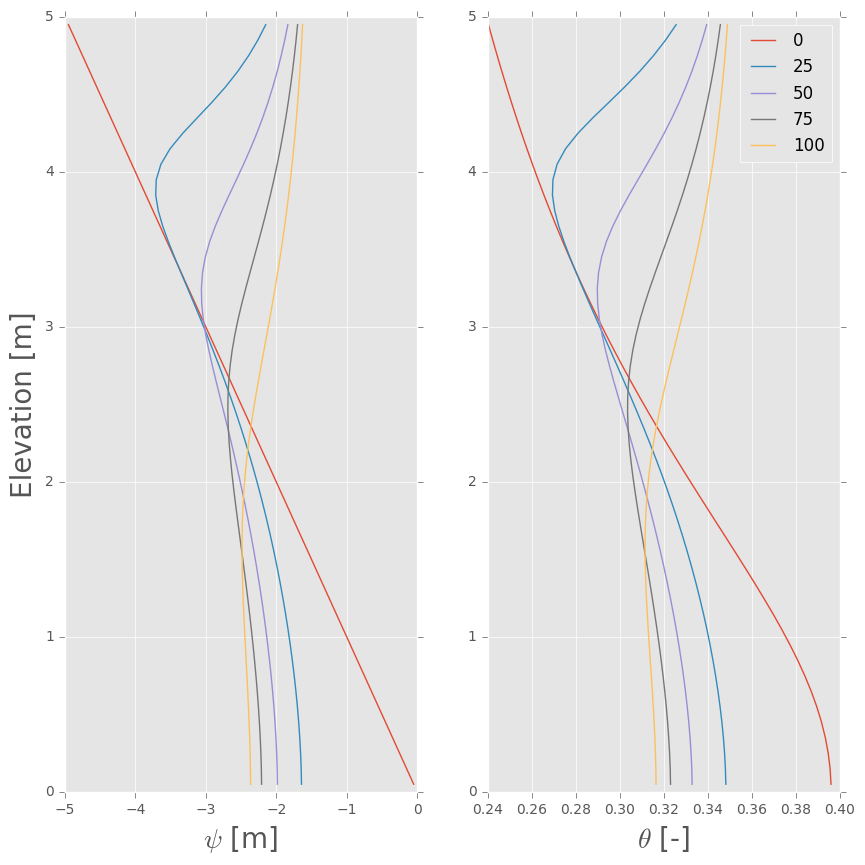

In [12]:
# Plot vertical profiles
plt.rcParams['figure.figsize'] = (10.0, 10.0)
for i in range(0,t.size,25):
    plt.subplot(121)
    plt.plot(psi[i,:],z, label = i)
    plt.subplot(122)
    plt.plot(theta[i,:],z, label = i)
    plt.legend()

plt.subplot(121)
plt.ylabel('Elevation [m]',fontsize=20)
plt.xlabel(r'$\psi$ [m]',fontsize=20)
plt.subplot(122)
plt.xlabel(r'$\theta$ [-]',fontsize=20)

(-0.05, 0.05)

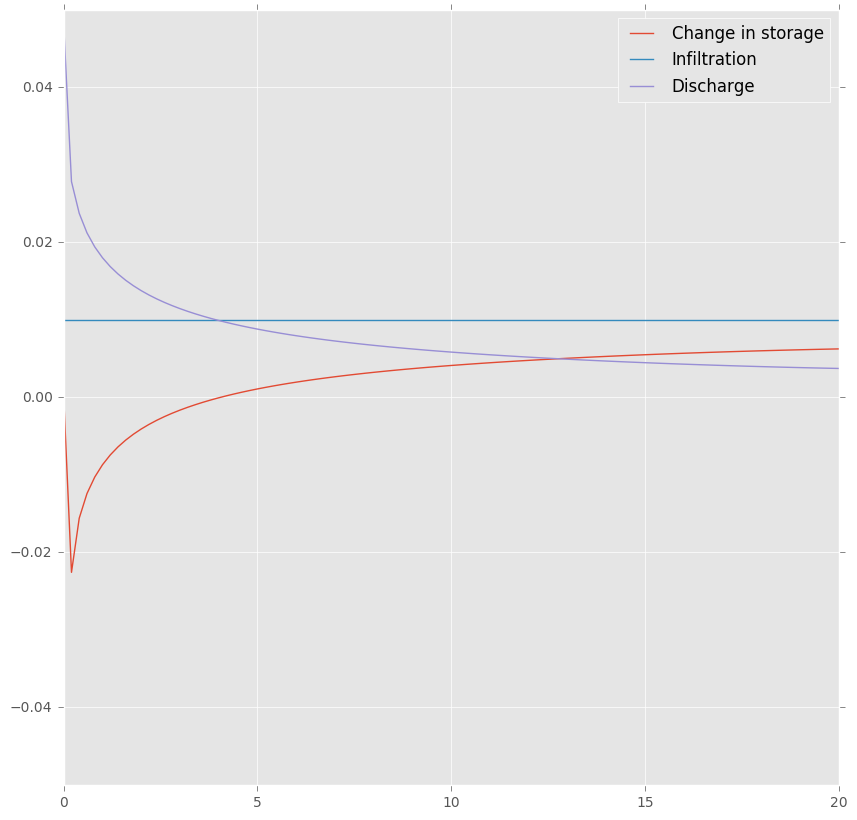

In [13]:
# Plot timeseries
dt = t[2]-t[1]
plt.plot(t,dS,label='Change in storage')
#plt.hold(True)
plt.plot(t,-qI,label='Infiltration')
plt.plot(t,-qD,label='Discharge')
plt.legend(loc="upper right")
plt.ylim((-.05,0.05))